## 1. Find the camera matrix and distortion Co-efficients

In [1]:
# import essential modules
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import os
# Configurations
%matplotlib qt
%matplotlib inline

In [2]:
def camera_calibration(directory_path=None):
    assert directory_path, "Please provide directory Path"
    
    path_calibration = directory_path
    calibration_images = os.listdir(path_calibration)

    obj_point_list = []
    img_point_list = []

    #Getting Objectpoints 
    obj_points = np.zeros((9*6,3), np.float32)
    obj_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    #iterating through all images in the folder 
    for image in calibration_images:
        # generate the actual path of the image
        img_path = os.path.join(path_calibration, image)
        img = mpimg.imread(img_path)
        # convert the image to gray scale as the findChessboardCorners takes only gray scale images
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
        if ret:
            obj_point_list.append(obj_points)
            img_point_list.append(corners)

    # get the camera matrix and distorted matrix
    return cv2.calibrateCamera(obj_point_list, img_point_list, gray.shape[::-1], None, None)

ret, mtx, dist, rvec, tvec = camera_calibration("camera_cal/")



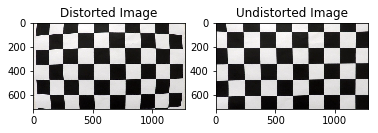

In [3]:
%matplotlib inline
img_path = os.path.join(path_calibration, "calibration1.jpg")
img = mpimg.imread(img_path)
plt.subplot(121)
plt.title("Distorted Image")
plt.imshow(img)
undistort = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(122)
plt.title("Undistorted Image")
plt.imshow(undistort)

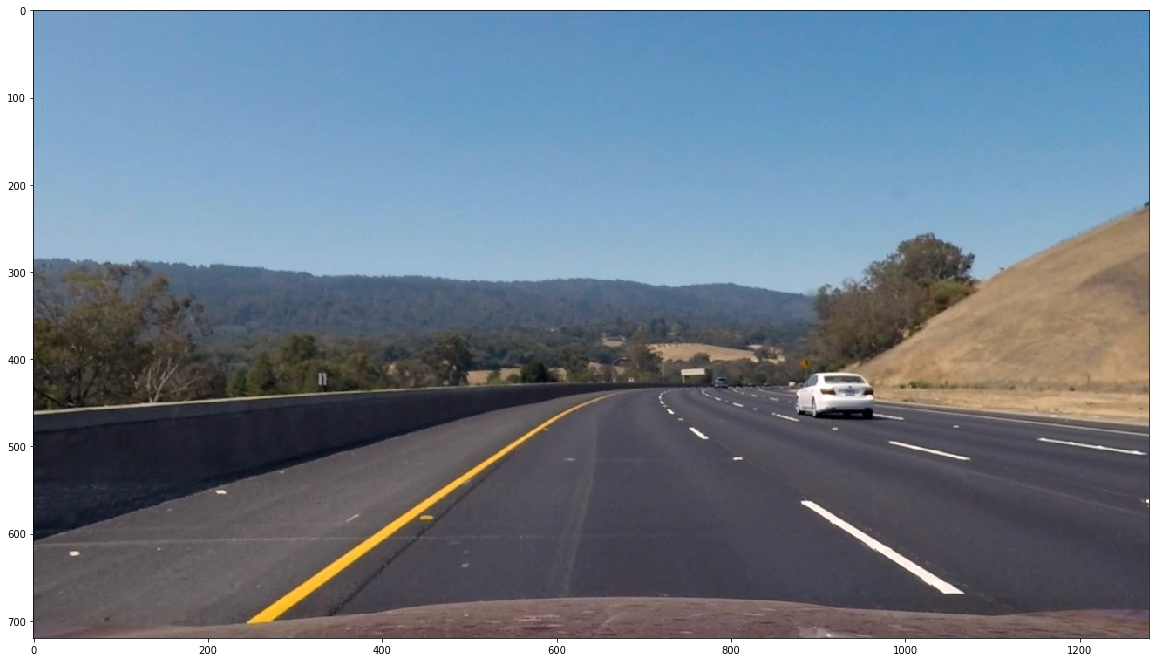

In [4]:
img_path = "test_images/test3.jpg"
# img_path = "test_images/straight_lines2.jpg"
img = mpimg.imread(img_path)
plt.figure(figsize=(20,20))
plt.imshow(img)
undistorted_original = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undistorted_original)

## Apply Color and Gradient Threshold

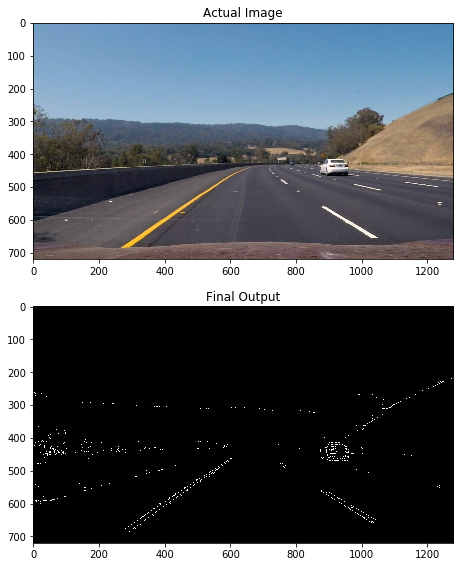

In [5]:
# Color Thresholding
plt.figure(figsize=(20,20))

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s = hls[:,:,2]

thresh = cv2.adaptiveThreshold(s, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 12)

#Magnitude Thresholding
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=3)
absolute_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
scaled_sobel = np.uint8(255 * absolute_sobel/ np.max(absolute_sobel))
binary_scaled = np.zeros_like(scaled_sobel)
binary_scaled[(scaled_sobel >= 10) & (scaled_sobel <= 150)] = 1

#Direction threholding
orientation = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
binary_orient = np.zeros_like(orientation)
binary_orient[(orientation >= 0) & (orientation <= 1.5)] = 1

combined = np.zeros_like(binary_orient)
combined[(binary_orient == 1) & (binary_scaled == 1)] =1

plt.subplot(411)
plt.title("Actual Image")
plt.imshow(img, cmap='gray')


color_gradient = np.zeros_like(combined)
color_gradient[(combined == 1) & (thresh ==1)] =1

plt.subplot(412)
plt.title("Final Output")
plt.imshow(color_gradient, cmap='gray')

## Performing Perspective Transformation of the image

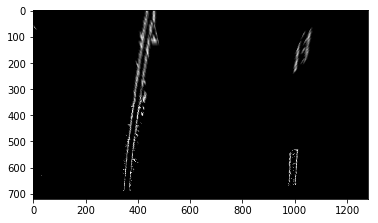

In [9]:
img = color_gradient
# h,w,_ = img.shape
# h,w = img.shape

midpoint = w // 2
offset_midpoint = 130

height_low = h //2 + 115
height_hight = h - 50

offset = 50

src = np.array([[midpoint-offset_midpoint, height_low],[midpoint+offset_midpoint, height_low],
                [midpoint+4.2*offset_midpoint, height_hight],[midpoint-4.2*offset_midpoint, height_hight]], np.float32)
# dst = np.array([[offset, offset],[w-offset, offset],
#                 [w-offset, h-offset],[offset, h-offset]], np.float32)

dst = np.array([[midpoint-3.7*offset_midpoint, offset],[midpoint+3.7*offset_midpoint, offset],
                [midpoint+3.5*offset_midpoint, height_hight],[midpoint-3.5*offset_midpoint, height_hight]], np.float32)

undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
# print(src)
# plt.scatter(midpoint-offset_midpoint, height_low, color='red')
# plt.scatter(midpoint+offset_midpoint, height_low, color='green')
# plt.scatter(midpoint+4.2*offset_midpoint, height_hight, color='white')
# plt.scatter(midpoint-4.2*offset_midpoint, height_hight, color='blue')

# plt.scatter(midpoint-4.2*offset_midpoint, offset, color='red')
# plt.scatter(midpoint+4*offset_midpoint, offset, color='green')
# plt.scatter(midpoint+4.2*offset_midpoint, height_hight, color='white')
# plt.scatter(midpoint-4.2*offset_midpoint, height_hight, color='blue')

# plt.imshow(undistort_img, cmap='gray')
M = cv2.getPerspectiveTransform(src,dst)
warp_img = cv2.warpPerspective(undistort_img, M, (w,h), cv2.INTER_LINEAR)
plt.imshow(warp_img, cmap='gray')

## Finding Lane Lines

### 1. Finding Lane Lines for the First Frame

In [7]:
img = warp_img
hist = np.sum(img[img.shape[0]//2:, :], axis=0)

midpoint = len(hist) // 2
left_current = np.argmax(hist[: midpoint])
right_current = np.argmax(hist[midpoint :]) + midpoint
print(left_current, right_current)
left_sum = np.max(hist[: midpoint])
right_sum = np.max(hist[midpoint :])
print(left_sum, right_sum, "Ration: {}".format(left_sum/right_sum* 0.1))
ratio = left_sum/right_sum * 0.1
# plt.figure(figsize=(30,30))
# plt.xticks(np.arange(0, 1280, step=20)) 
# plt.imshow(img[img.shape[0]//2:, :],cmap='gray')

1101 1711
64190 50001 Ration: 0.128377432451351


#### It was found that the difference between the lane lines in Warped Image for the Current transfom is 600pixels

### 2. Try to find the PolyNomial

In [8]:
nwindows = 20
minpiixels = 50
margin = 100
height, width = img.shape
nonzero = np.nonzero(img)
nonzerox = nonzero[1]
nonzeroy = nonzero[0]
# print(len(nonzerox), len(nonzeroy))
left_inds = []
right_inds = []
window_height = height // nwindows
for i in range(nwindows):
    win_height_high = height - i*window_height
    win_height_low = height - (i+1)*window_height
    
    win_left_min = left_current - margin
    win_left_max = left_current + margin
    win_right_min = right_current - margin
    win_right_max = right_current + margin
    print("Win Height[{}, {}], left Wind[{},{}], Right Wind[{},{}]"
          .format(win_height_low, win_height_high, win_left_min, win_left_max,
                 win_right_min, win_right_max))
    

    
    left_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                         (nonzerox >= win_left_min)&(nonzerox <= win_left_max)).nonzero()[0]
    right_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                         (nonzerox >= win_right_min)&(nonzerox <= win_right_max)).nonzero()[0]
    
    print(len(left_current_inds), len(right_current_inds))
#     print(left_current_inds.shape, right_current_inds.shape)
    left_inds.append(left_current_inds)
    right_inds.append(right_current_inds)
    
    if len(left_current_inds) > minpiixels:
        new_left =  int(np.mean(nonzerox[left_current_inds]))
        expected_left = right_current - 600
#         print("UPDATING LEFT: new_left: {}, expected_left: {}".format(new_left, expected_left))
        left_current =  int(np.mean([new_left,expected_left]))
#         print("UPDATING LEFT: Difference between Left and Right is : {}".format(right_current - left_current))
    if len(right_current_inds) > minpiixels:
        new_right = int(np.mean(nonzerox[right_current_inds]))
        expected_current = left_current + 600
#         print("\tUPDATING RIGHT: new_right: {}, expected_current: {}".format(new_right, expected_current))
        right_current =  int(np.mean([new_right,expected_current]))
#         print("\tUPDATING RIGHT:Difference between Left and Right is : {}".format(right_current - left_current))
        
left_inds = np.concatenate(left_inds)
right_inds = np.concatenate(right_inds)

        
left_x = nonzerox[left_inds]
left_y = nonzeroy[left_inds]
right_x = nonzerox[right_inds]
right_y = nonzeroy[right_inds]


left_fit = np.polyfit(left_y, left_x, 2)
right_fit = np.polyfit(right_y, right_x, 2)

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]


# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(img, cmap='gray')

ValueError: too many values to unpack (expected 2)

In [ ]:
left_fit = np.polyfit(left_y, left_x, 2)
right_fit = np.polyfit(right_y, right_x, 2)

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]


# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(img, cmap='gray')

In [ ]:
ym_per_pix = 30/720 
xm_per_pix = 3.7/700

# Calculating the Curvature
def calculate_curvature(line_fit,y_value, multiplier=1):
    a_times_2 = 2*line_fit[0]
    y_val = np.max(y_value)*multiplier
    curvature = ((1+(a_times_2*y_val + line_fit[1])**2)**1.5) / np.absolute(a_times_2)
    return curvature

print(calculate_curvature(left_fit, ploty))
print(calculate_curvature(right_fit, ploty))

In [ ]:
#Calculate curvature in mts

def fit_line_mts(y,x):
    line_fir = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    return line_fir

print(calculate_curvature(fit_line_mts(left_y, left_x), ploty, ym_per_pix),"m")
print(calculate_curvature(fit_line_mts(right_y, right_x), ploty, ym_per_pix),"m")

In [ ]:
img_warp = warp_img
out_img = np.dstack((img_warp, img_warp, img_warp)) *255

window_img = np.zeros_like(out_img)
plt.imshow(out_img, cmap='gray')

In [ ]:
left_line_points = np.array([np.vstack((left_fitx, ploty)).T])
right_line_points = np.array([np.flipud(np.vstack((right_fitx, ploty)).T)])
lane_pts = np.hstack((left_line_points, right_line_points))

cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255,0))

result = cv2.addWeighted(out_img, 0.0, window_img, 0.99, 0)
# print(out_img.dtype)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(result)

In [ ]:
M_inv = cv2.getPerspectiveTransform(dst,src)
un_warp_img = cv2.warpPerspective(result, M_inv, (w,h))


# Due to the changes in Format in original image and unwarp image, we need to normalize the values
img_n = cv2.normalize(src=un_warp_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

actual_image_region = cv2.addWeighted(undistorted_original, 1, img_n , 0.8,0)
plt.figure(figsize=(50,50))
plt.imshow(actual_image_region)

